In [1]:
from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
import torch
from torch.nn import TransformerEncoder, TransformerEncoderLayer, Embedding, RNN
from torch.nn import Linear, Sigmoid, Softmax
from torch.nn import NLLLoss, CrossEntropyLoss
from torch.optim import SGD

from torch.nn import MSELoss, L1Loss, BCELoss
from torch.optim import Adam

In [3]:
from nets import LM, AggregateHead, ReconstructHead, GAN

In [4]:
from utils import iter_batches, merge_and_shuffle

# Data

In [5]:
val = 1
ind = 0
def val_in_seq(data):
    return torch.tensor([val in seq for seq in data]).unsqueeze(1).float()
def val_at_index(data):
    return (data[:, ind] == val).unsqueeze(1).float()

def is_sorted(data):
    return ((X.sort(1).values == X).sum(1) == X.shape[1]).unsqueeze(1).float()

def sum_of_seq(data):
    return data.sum(1).unsqueeze(1).float()


task_function = sum_of_seq    

In [6]:
n, k, V, d = 100, 3, 5, 1
X = torch.randint(V, size=(n, k))
Y = task_function(X)

eval_X = torch.randint(V, size=(10, k))
eval_Y = sum_of_seq(eval_X)

### GAN Data

In [7]:
# true_X = torch.randint(100, (50, 6, 3)).float()
true_X = X
fake_X = torch.randint(V, (n, k))

gan_X, gan_Y = merge_and_shuffle(true_X, fake_X)
gan_Y = gan_Y.unsqueeze(-1).float()

true_eval_X, fake_eval_X = eval_X, torch.randint(V, (10, k))  #.float()
gan_eval_X, gan_eval_Y = merge_and_shuffle(true_eval_X, fake_eval_X)

----
# GAN Test Training

In [8]:
# gan = GAN(V, 7)

# losses = []

In [9]:
# criterion = BCELoss()
# opt = SGD(gan.parameters(), lr=0.01)

In [10]:
# for _ in tqdm(range(50)):
#     opt.zero_grad()

#     preds = gan(gan_X)

#     loss = criterion(preds, gan_Y)

#     loss.backward()
#     opt.step()
        
#     losses.append(loss)

In [11]:
# plt.plot(range(len(losses)), losses, '--')

In [12]:
# gan.eval()
# list(zip(gan(gan_eval_X).detach(), gan_eval_Y))

# Instantiations

In [13]:
lm = LM(V, embed_dim=64, num_layers=2)

sum_head = AggregateHead(lm, aggregate_function=AggregateHead.aggr_sum)

recon = ReconstructHead(lm)
gan = GAN(V, 7)

losses = {"head":[], "recon":[], "gan":[]}

criterion = MSELoss()
gan_criterion = BCELoss()

recon_criterion = CrossEntropyLoss()

optim = SGD(lm.parameters(), lr=0.01)
gan_optim = Adam(gan.parameters(), lr=0.1)

/home/valentin/.local/lib/python3.6/site-packages/torch/nn/modules/rnn.py:61: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


# Training

In [14]:
# pre-train GAN for now
# not possible: missing source for fake vectors
# for _ in tqdm(range(100)):
#     gan_optim.zero_grad()
    
    

In [15]:
alpha = 0.3

lm.train()
sum_head.train()
gan.train()

for _ in tqdm(range(2000)):
    optim.zero_grad()
    
    encoded = lm(X)
    
    # use both heads
    sums = sum_head(encoded)
    recon_X = recon(encoded)
#     print(recon_X.shape, X.flatten().shape, recon_X.view(-1, 5).shape)
#     print(sums.shape, Y.shape)
    
    head_loss = criterion(sums, Y)
    recon_loss = gan.loss(recon_X.argmax(-1))
    
    loss = alpha*head_loss + (1-alpha)*recon_loss  # loss =  alpha*criterion(sums, Y) + recon_criterion(recon_X.view(-1, V), X.flatten())
    loss.backward()
    optim.step()
    losses["head"].append(head_loss.detach())
    losses["recon"].append(recon_loss.detach())
    
    
    # TRAIN GAN
    gan_optim.zero_grad()
    gan_X, gan_Y = merge_and_shuffle(X, recon_X.argmax(-1))
    
    judgements = gan(gan_X)
    gan_loss = gan_criterion(judgements, gan_Y.unsqueeze(-1).float())

    gan_loss.backward()
    gan_optim.step()
    losses["gan"].append(gan_loss.detach())

  0%|          | 0/2000 [00:00<?, ?it/s]/home/valentin/.local/lib/python3.6/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag
100%|██████████| 2000/2000 [01:29<00:00, 22.29it/s]


# Inspection

(0.0, 1.0)

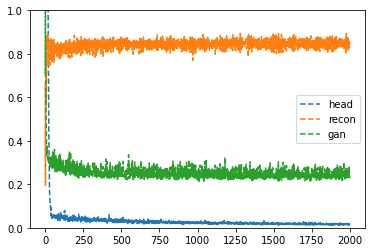

In [19]:
for name, ls in losses.items(): plt.plot(range(len(ls)), ls, "--", label=name)
plt.legend()
plt.ylim([0.0, 1.0])

In [20]:
eval_enc = lm(eval_X)
eval_rec = recon(eval_enc).argmax(-1)

print(list(zip(sum_head(eval_enc).detach(), eval_Y)))
print()
print(list(zip(eval_rec, eval_X)))

print()
eval_gan_X, eval_gan_Y = merge_and_shuffle(eval_X, eval_rec)

js = gan(eval_gan_X)
print(list(zip(js.detach(), eval_gan_Y)))

[(tensor([4.2158]), tensor([4.])), (tensor([6.1145]), tensor([6.])), (tensor([5.8726]), tensor([6.])), (tensor([9.9936]), tensor([10.])), (tensor([1.7349]), tensor([2.])), (tensor([3.8986]), tensor([4.])), (tensor([10.1404]), tensor([10.])), (tensor([5.1026]), tensor([5.])), (tensor([7.6820]), tensor([8.])), (tensor([9.8940]), tensor([10.]))]

[(tensor([1, 3, 3]), tensor([3, 1, 0])), (tensor([1, 3, 2]), tensor([4, 0, 2])), (tensor([2, 1, 3]), tensor([2, 4, 0])), (tensor([1, 1, 1]), tensor([3, 4, 3])), (tensor([3, 3, 3]), tensor([1, 1, 0])), (tensor([3, 3, 1]), tensor([0, 1, 3])), (tensor([1, 1, 1]), tensor([3, 4, 3])), (tensor([3, 3, 1]), tensor([0, 1, 4])), (tensor([3, 1, 1]), tensor([1, 3, 4])), (tensor([1, 1, 1]), tensor([3, 4, 3]))]

[(tensor([0.0104]), tensor(0)), (tensor([0.2486]), tensor(0)), (tensor([0.2593]), tensor(0)), (tensor([0.9938]), tensor(1)), (tensor([0.2593]), tensor(0)), (tensor([1.0000]), tensor(1)), (tensor([0.9921]), tensor(1)), (tensor([0.2499]), tensor(0)), (te

In [34]:
rand = torch.randint(V, size=(500, k))
recon_vecs = recon(lm(rand)) 

In [50]:
from collections import Counter

vals = rand.flatten().tolist()
real_counts = sorted(Counter(vals).items(), key=lambda t: t[0])

[(0, 303), (1, 304), (2, 299), (3, 289), (4, 305)]

In [49]:
recon_vecs.sum(0).sum(0)

tensor([222.7667, 396.4016, 336.0142, 319.6255, 225.1921],
       grad_fn=<SumBackward1>)